In [1]:
%matplotlib inline  

In [2]:
import torch
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import pickle
import os
import warnings 
warnings.simplefilter("ignore", UserWarning)

In [3]:
os.chdir("..")

In [4]:
from Prior_optimization.gpr import GPR
from Prior_optimization import kernels, mean_functions
from Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Samplers.likelihoods import LikGaussian
from Prior_optimization.priors import OptimGaussianPrior
from Utilities.rand_generators import MeasureSetGenerator
from Utilities.normalization import normalize_data
from Utilities.exp_utils import get_input_range
from Metrics.sampling import compute_rhat_regression
from Metrics import uncertainty as uncertainty_metrics
from Networks.mlp_masked import MLPMasked
from Networks.regression_net_masked import RegressionNetMasked
from Prior_optimization.optimisation_mapper import PriorOptimisationMapper
from Utilities import util
from Utilities.priors import LogNormal

In [5]:
mpl.rcParams['figure.dpi'] = 100

In [6]:
SEED = 123
util.set_seed(SEED)

In [7]:
# Network architecture
n_units = 100
n_hidden = 1
activation_fn = "tanh"

In [8]:
# Dataset configurations
n_splits = 10
dataset = "boston"
data_dir = "./data/uci"
noise_var = 0.1

In [9]:
# setting device on GPU if available, else CPU
n_gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    n_gpu +=1

Using device: cpu 



# 1. Optimized Gaussian Prior

In [10]:
out_dir = "./exp/uci/optim_gaussian"
util.ensure_dir(out_dir)

## 1.1 Optimize the prior

In [ ]:
num_iters = 4000  # Number of iteterations of Prior optimization # 4000
lr = 0.05        # The learning rate
n_samples = 128  # The mini-batch size
lambd_sd = torch.tensor([3.5]).to(device) # Vetcor of penalization terms #2.5
D = 3            # Depth for pruning of standard deviations
num_samples = 30
print_every = 100
n_data = 128

In [12]:
masks_list = []
for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    # Load the dataset
    saved_dir = os.path.join(out_dir, str(split_id))
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    X_train_, y_train_, X_test_, y_test_, y_mean, y_std = normalize_data(
            X_train, y_train, X_test, y_test)
    x_min, x_max = get_input_range(X_train_, X_test_)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    # Initialize the measurement set generator
    rand_generator = MeasureSetGenerator(X_train_, x_min, x_max, 0.7)
    
    # Initialize the mean and covariance function of the target hierarchical GP prior
    mean = mean_functions.Zero()
    
    lengthscale = math.sqrt(2. * input_dim)
    variance = 1.
    # BEFORE RBF
    kernel = kernels.Exponential(input_dim=input_dim,
                         lengthscales=torch.tensor([lengthscale], dtype=torch.double),
                         variance=torch.tensor([variance], dtype=torch.double), ARD=True)

    # Place hyper-priors on lengthscales and variances
    kernel.lengthscales.prior = LogNormal(
            torch.ones([input_dim]) * math.log(lengthscale),
            torch.ones([input_dim]) * 1.)
    kernel.variance.prior = LogNormal(
            torch.ones([1]) * 0.1,
            torch.ones([1]) * 1.)
        
    # Initialize the GP model
    gp = GPR(X=torch.from_numpy(X_train_), Y=torch.from_numpy(y_train_).reshape([-1, 1]),
             kern=kernel, mean_function=mean)
    gp.likelihood.variance.set(noise_var)
    gp = gp.to(device)
    
    # Initialize tunable MLP prior
    hidden_dims = [n_units] * n_hidden
    mlp_reparam = FactorizedGaussianMLPReparameterization(input_dim, output_dim,
        hidden_dims, D = D, activation_fn=activation_fn, scaled_variance=True, device=device)
    # Perform optimization
    mapper = PriorOptimisationMapper(out_dir=saved_dir).to(device)
    p_hist, loss_hist = mapper.optimize(net = mlp_reparam, gp = gp, data_generator = rand_generator, 
            lambd= lambd_sd, n_data = n_data, num_iters = num_iters, print_every=print_every, output_dim = 1, 
            D= D, n_samples = num_samples)
    path = os.path.join(saved_dir, "loss_values.log")
    if not os.path.isfile(saved_dir):
        os.makedirs(saved_dir, exist_ok=True)
    np.savetxt(path, loss_hist, fmt='%.6e')
    path = os.path.join(saved_dir, "pruned_values.log")
    if not os.path.isfile(saved_dir):
        os.makedirs(saved_dir, exist_ok=True)
    np.savetxt(path, p_hist, fmt='%.6e')
    print("----" * 20)
    masks_list.append(mlp_reparam.get_det_masks())
# Save the masks
with open(os.path.join(out_dir, "masks_list.pkl"), "wb") as f:
    pickle.dump(masks_list, f)

Loading split 1 of boston dataset
>>> Iteration #   1: Energy Distance 0.1155 Number of pruned stochastic weights: 0
>>> Iteration # 100: Energy Distance 0.0834 Number of pruned stochastic weights: 1
>>> Iteration # 200: Energy Distance 0.0980 Number of pruned stochastic weights: 1
>>> Iteration # 300: Energy Distance 0.1053 Number of pruned stochastic weights: 4
>>> Iteration # 400: Energy Distance 0.0777 Number of pruned stochastic weights: 9
>>> Iteration # 500: Energy Distance 0.1146 Number of pruned stochastic weights: 20
>>> Iteration # 600: Energy Distance 0.0904 Number of pruned stochastic weights: 27
>>> Iteration # 700: Energy Distance 0.1098 Number of pruned stochastic weights: 45
>>> Iteration # 800: Energy Distance 0.0911 Number of pruned stochastic weights: 57
>>> Iteration # 900: Energy Distance 0.2140 Number of pruned stochastic weights: 72
>>> Iteration # 1000: Energy Distance 0.1222 Number of pruned stochastic weights: 88
>>> Iteration # 1100: Energy Distance 0.1505 N

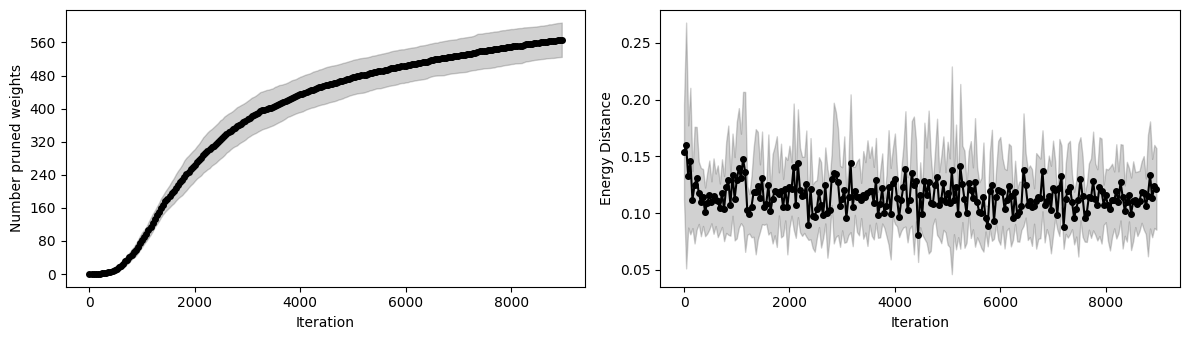

In [13]:
# Visualize the convergence
lossdist_data = []
pruned_vals_data = []
for i in range(0, n_splits):
    lossdist_file = os.path.join(out_dir, str(i), "loss_values.log")
    pruned_vals_file = os.path.join(out_dir, str(i), "pruned_values.log")
    lossdist_data.append(np.loadtxt(lossdist_file))
    pruned_vals_data.append(np.loadtxt(pruned_vals_file))

lossdist_vals = np.stack(lossdist_data)
pruned_vals = np.stack(pruned_vals_data)
indices = np.arange(num_iters)[::40]
mean_loss = lossdist_vals.mean(0)
std_loss = lossdist_vals.std(0)
mean_pruned = pruned_vals.mean(0)
std_pruned = pruned_vals.std(0)

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, mean_pruned[indices], "ko", ms=4)
axes[0].fill_between(indices, mean_pruned[indices] - std_pruned[indices],
                 mean_pruned[indices] + std_pruned[indices], alpha=0.18, color="k")
axes[0].set_ylabel("Number pruned weights")
axes[0].set_xlabel("Iteration")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, mean_loss[indices], "-ko", ms=4)
axes[1].fill_between(indices, mean_loss[indices]-std_loss[indices],
                     mean_loss[indices]+std_loss[indices], alpha = 0.18, color = "k")
axes[1].set_ylabel("Energy Distance")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()

## 1.2 Posterior Inference

In [ ]:
sampling_configs = {
    "batch_size": 32,                 # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,         # Number of burn-in steps
    "keep_every": 2000,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}

# Load the masks
with open(os.path.join(out_dir, "masks_list.pkl"), "rb") as f:
    masks_list = pickle.load(f)

In [15]:
results = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    # Initialize the neural network and likelihood modules
    weight_mask, bias_mask = masks_list[split_id]
    net = MLPMasked(input_dim, output_dim, [n_units] * n_hidden, activation_fn, weight_mask, 
                    bias_mask, device = device)
    net = net.to(device)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir, str(split_id), "ckpts", "it-{}.ckpt".format(num_iters))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNetMasked(net, likelihood, prior, saved_dir, n_gpu=n_gpu)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results['rmse'].append(rmse)
    results['nll'].append(nll)

Loading split 1 of boston dataset
Chain: 1
Samples #     5 : NLL =  2.2640e+00 RMSE = 1.7570e+00 
Samples #    10 : NLL =  2.2540e+00 RMSE = 1.6184e+00 
Samples #    15 : NLL =  2.2516e+00 RMSE = 1.5882e+00 
Samples #    20 : NLL =  2.2550e+00 RMSE = 1.5583e+00 
Samples #    25 : NLL =  2.2529e+00 RMSE = 1.5352e+00 
Samples #    30 : NLL =  2.2520e+00 RMSE = 1.5257e+00 
Chain: 2
Samples #    35 : NLL =  2.2496e+00 RMSE = 1.4838e+00 
Samples #    40 : NLL =  2.2467e+00 RMSE = 1.4528e+00 
Samples #    45 : NLL =  2.2465e+00 RMSE = 1.4396e+00 
Samples #    50 : NLL =  2.2443e+00 RMSE = 1.4202e+00 
Samples #    55 : NLL =  2.2432e+00 RMSE = 1.4090e+00 
Samples #    60 : NLL =  2.2420e+00 RMSE = 1.4067e+00 
Chain: 3
Samples #    65 : NLL =  2.2416e+00 RMSE = 1.3868e+00 
Samples #    70 : NLL =  2.2417e+00 RMSE = 1.3725e+00 
Samples #    75 : NLL =  2.2404e+00 RMSE = 1.3624e+00 
Samples #    80 : NLL =  2.2391e+00 RMSE = 1.3471e+00 
Samples #    85 : NLL =  2.2391e+00 RMSE = 1.3444e+00 
Samp

In [16]:
result_df = pd.DataFrame(results)
result_df.to_csv(os.path.join(out_dir, "optim_results.csv"), sep="\t", index=False)

### Final Result

In [17]:
result_df = pd.read_csv(os.path.join(out_dir, "optim_results.csv"), sep = "\t")
print("Final result:")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df['rmse'].mean()), float(result_df['rmse'].std()),
        float(result_df['nll'].mean()), float(result_df['nll'].std())))
print("\nFinal results benchmark:")
print("> RMSE: mean 2.7970e+00; std 9.1485e-01 | NLL: mean 2.4699e+00 std 1.4601e-01")

Final result:
> RMSE: mean 2.8302e+00; std 8.5204e-01 | NLL: mean 2.4722e+00 std 6.8537e-02

Final results benchmark:
> RMSE: mean 2.7970e+00; std 9.1485e-01 | NLL: mean 2.4699e+00 std 1.4601e-01
